In [1]:
from hacktops.model import TopFinder
from tslearn.metrics import dtw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hacktops.data import generate_top_dataset
from sklearn.model_selection import StratifiedShuffleSplit
from hacktops.utils import instance_norm
import random
import plotly.graph_objs as go
from plotly.offline import iplot

random.seed(0)

/usr/users/bdmagr4/luo/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
top_ = 'CONRAD'
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")


In [3]:
all_well_names = df_logs_['wellName'].unique()
print('all well num:', len(all_well_names))

test_well_names = random.sample(all_well_names.tolist(), int(len(all_well_names) * 0.1))
train_well_names = [wn for wn in all_well_names.tolist() if wn not in test_well_names]

print('test_well_names num:', len(test_well_names))
print('train_well_names num:', len(train_well_names))
test_well_names[1]

all well num: 600
test_well_names num: 60
train_well_names num: 540


512329990.0

In [4]:
train_dataset = generate_top_dataset(df_logs=df_logs_[df_logs_['wellName'].isin(train_well_names)], df_tops=df_tops_, top=top_)
print(len(train_dataset[0]))

NAN FOUND
NAN FOUND
NAN FOUND
NAN FOUND
107196


In [5]:
test_dataset = generate_top_dataset(df_logs=df_logs_[df_logs_['wellName'].isin(test_well_names)], df_tops=df_tops_, top=top_)
print(len(test_dataset[0]))

12000


X: (107196, 61)
y: (107196,)
train_dataset_true_idx num: 8040


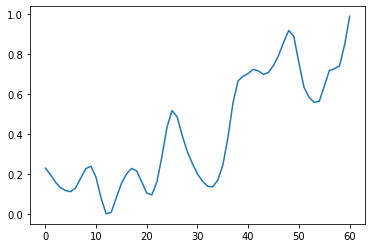

In [6]:
X = np.array(train_dataset[0]).squeeze(axis=2)
y = np.array(train_dataset[1])

X = np.array([instance_norm(x) for x in X])
    
print('X:', X.shape)
print('y:', y.shape)

# The model needs only true windows
train_dataset_true_idx = [idx for idx in range(len(X)) if y[idx] == True]
print('train_dataset_true_idx num:', len(train_dataset_true_idx))

plt.plot(X[train_dataset_true_idx[1]])

In [7]:
class WindowEvaluator:
    def __init__(self, metric=dtw):
        self.metric = metric

    def fit(self, X):
        self._X = X

    def predict_proba(self, X):
        res = []
        for x in X:
            dists = np.array([self.metric(_x, x) for _x in self._X])
            weights = 1/(1+dists)
            res.append(weights.sum()/weights.shape[0])
        return res

In [8]:
neigh = WindowEvaluator(metric=dtw)
neigh.fit(X[train_dataset_true_idx])

top_finder = TopFinder(neigh, top_)
neigh.evaluate_windows = neigh.predict_proba
top_finder.examine_dataset(df_tops_)

In [41]:
from datetime import datetime 

df_tops_true = df_tops_[[top_]].filter(items = test_well_names, axis=0).copy()
df_tops_pred = df_tops_true.copy()
df_tops_pred[top_] = 0

count = 1
for test_well_name in test_well_names:
    print(f'{count}/{len(test_well_names)} : {test_well_name}')
    count += 1
    df_test_well = df_logs_[df_logs_['wellName'] == test_well_name]
    windows = top_finder.get_candidate_windows(df_test_well)
    windows = [(w[0], np.array(instance_norm(w[1]))) for w in windows]

    print('\twindows candidate size:', len(windows))
    windows_depth = np.array([w[0] for w in windows])
    windows_data = np.array([w[1] for w in windows])
    
    true_depth = df_tops_.loc[test_well_name, top_]
    print('\ttrue depth: ', true_depth)
    temp = [w for w in windows if w[0]==true_depth]
    if len(temp) == 0 or np.isnan(true_depth):
        print('\tdid not find matched log of true depth, continue')
        continue
    true_window = temp[0]
    # start_time = datetime.now() 
    # proba = neigh.predict_proba(windows_data)
    # time_elapsed = datetime.now() - start_time 
    # print('\tTime elapsed: {}'.format(time_elapsed))

    # np.savetxt(f"./test_output/{str(test_well_name)}.txt", np.array(proba),fmt='%f',delimiter=',')
    np_proba = np.loadtxt(f"./test_output/{str(test_well_name)}.txt",delimiter=',')

    max_idx = np.argmax(np_proba)
    max_score_depth = windows_depth[max_idx]
    print('\tmax score depth:', max_score_depth)
    max_score_window = windows_data[max_idx]
    
    df_tops_pred.loc[test_well_name, top_] = max_score_depth
    
print('end')


1/60 : 512329258.0
	windows candidate size: 1944
	true depth:  6739.0
	max score depth: 6737.5
2/60 : 512329990.0
	windows candidate size: 1728
	true depth:  6253.0
	max score depth: 6246.0
3/60 : 512322801.0
	windows candidate size: 1854
	true depth:  6730.0
	max score depth: 6729.0
4/60 : 512326191.0
	windows candidate size: 1946
	true depth:  6828.0
	max score depth: 6829.0
5/60 : 512331861.0
	windows candidate size: 1458
	true depth:  6534.0
	max score depth: 6529.0
6/60 : 512331250.0
	windows candidate size: 1640
	true depth:  6635.0
	max score depth: 6633.0
7/60 : 512329492.0
	windows candidate size: 1916
	true depth:  6785.0
	max score depth: 6784.5
8/60 : 512326769.0
	windows candidate size: 1638
	true depth:  6616.0
	max score depth: 6616.0
9/60 : 512331193.0
	windows candidate size: 1816
	true depth:  6724.0
	max score depth: 6724.5
10/60 : 512327287.0
	windows candidate size: 2318
	true depth:  6942.0
	max score depth: 6946.0
11/60 : 512335135.0
	windows candidate size: 2270

In [42]:
df_tops_pred

,CONRAD
wellName,
512329258.0,6737.5
512329990.0,6246.0
512322801.0,6729.0
512326191.0,6829.0
512331861.0,6529.0
512331250.0,6633.0
512329492.0,6784.5
512326769.0,6616.0
512331193.0,6724.5


In [43]:
from hacktops.evaluate import recall_tops

recall, mae, df_res = recall_tops(df_tops_true, df_tops_pred, tolerance = 4)
print("recall {0}, mae {1}".format(recall,mae))
df_res.head(50)

recall 0.7666666666666667, mae 12.891666666666667


,CONRAD,CONRAD_pred,CONRAD_ae,CONRAD_tp
wellName,,,,
512329258.0,6739.0,6737.5,1.5,True
512329990.0,6253.0,6246.0,7.0,False
512322801.0,6730.0,6729.0,1.0,True
512326191.0,6828.0,6829.0,1.0,True
512331861.0,6534.0,6529.0,5.0,False
512331250.0,6635.0,6633.0,2.0,True
512329492.0,6785.0,6784.5,0.5,True
512326769.0,6616.0,6616.0,0.0,True
512331193.0,6724.0,6724.5,0.5,True


In [44]:
test_well_name = 512333171.0
df_test_well = df_logs_[df_logs_['wellName'] == test_well_name]
windows = top_finder.get_candidate_windows(df_test_well)
windows = [(w[0], np.array(instance_norm(w[1]))) for w in windows]

print('\twindows candidate size:', len(windows))
windows_depth = np.array([w[0] for w in windows])
windows_data = np.array([w[1] for w in windows])

true_depth = df_tops_.loc[test_well_name, top_]
print('\ttrue depth: ', true_depth)
temp = [w for w in windows if w[0]==true_depth]
if len(temp) == 0 or np.isnan(true_depth):
    print('\tdid not find matched log of true depth, continue')
else:
    true_window = temp[0]
# start_time = datetime.now() 
# proba = neigh.predict_proba(windows_data)
# time_elapsed = datetime.now() - start_time 
# print('\tTime elapsed: {}'.format(time_elapsed))

# np.savetxt(f"./test_output/{str(test_well_name)}.txt", np.array(proba),fmt='%f',delimiter=',')
np_proba = np.loadtxt(f"./test_output/{str(test_well_name)}.txt",delimiter=',')

max_idx = np.argmax(np_proba)
max_score_depth = windows_depth[max_idx]
print('\tmax score depth:', max_score_depth)
max_score_window = windows_data[max_idx]

df_tops_pred.loc[test_well_name, top_] = max_score_depth

	windows candidate size: 1780
	true depth:  6553.0
	max score depth: 6692.5


In [45]:
data = []
data.append(go.Scatter(x=windows_depth,y=np_proba))
fig = go.Figure(data=data)
fig.add_vline(x=true_depth, line_width=2, line_color="green")
fig.add_vline(x=max_score_depth, line_width=2, line_color="yellow")
iplot(fig)

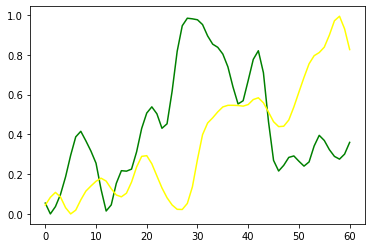

In [46]:
plt.plot(true_window[1], label='true window', color='green')
plt.plot(max_score_window, label='max score window', color='yellow')